In [1]:
# import libraries

import pandas as pd
import numpy as np

from ml_metrics import rmsle
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split, GridSearchCV

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

import scikitplot as skplt


import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

#### Load the data

In [2]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [3]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,Autumn,Spring,Summer,Winter,icon_num,summary_num
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,41.406660,37.978489,0.625938,2.070653,3.960878,3.957379,32.930000,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.930000,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.245,0.0,1.497083,262.5,8.1875,28.372083,0.884583,32.77875,0.922917,0.0,0.0,1027.697222,34.817083,0.0,3.255,268.5,8.880417,21.833036,0.65503,24.675714,0.777679,0.0,0.0,1020.708333,31.03006,0.005952,5.732369,231.767857,12.58,29.673403,0.703438,30.910208,0.820625,0.001033,0.029861,1016.38912,35.949792,0.0,6.1025,212.916667,8.614931,30.76,0.75,33.73,0.83,0.0,0.0,1016.232609,36.925,0.0,6.216,223.0,7.595,23.315924,0.700556,25.432738,0.836071,0.000674,0.022361,1015.459669,29.965072,0.076122,5.640179,195.026175,8.034874,24.855,0.75,27.9,0.86,0.0,0.0,1016.5,31.94,0.0,6.215,207.5,7.465,0,0,0,1,0,0
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,

#### Split the data for train and test

In [4]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [5]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [6]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

#### Select original features and run simple models for benchmarking purpose

In [7]:
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability', 'pressure', 'temperature',
              'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'icon_num', 'summary_num']

In [8]:
def run_model(feats, model, tcsv):
    X = df_train[feats].values
    y = df_train['PM25_nie_log'].values
    
    def perform_scoring(y_true_log, y_log_pred):
        y_true = np.expm1(y_true_log)
        y_pred = np.expm1(y_log_pred)
        return rmsle(y_true, y_pred)
    
    model_name = type(model).__name__
    
    scoring = make_scorer(perform_scoring, greater_is_better=False)
    rmse = -cross_val_score(model, X, y, cv=tcsv, scoring=scoring)
    r2 = cross_val_score(model, X, y, cv=tcsv, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [9]:
# define Time Series Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)

# define simple models for fast testing
DT_model = DecisionTreeRegressor(max_depth=5, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=5, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', random_state=random_state)
LGB_model = lgb.LGBMRegressor(max_depth=5, objective='regression', random_state=random_state)

In [10]:
models = [DT_model, RF_model, XGB_model, LGB_model]

for model in models:
    run_model(orig_feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.4699, r2: 32.1%
RandomForestRegressor RMSE: 0.4495, r2: 37.9%
XGBRegressor RMSE: 0.4664, r2: 27.8%
LGBMRegressor RMSE: 0.4655, r2: 28.0%


#### Quick check of XGBoost prediction errors

In [11]:
X = df_train[orig_feats].values
y = df_train['PM25_nie_log'].values

X_test = df_test[orig_feats].values

model = xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', random_state=random_state)
model.fit(X, y)

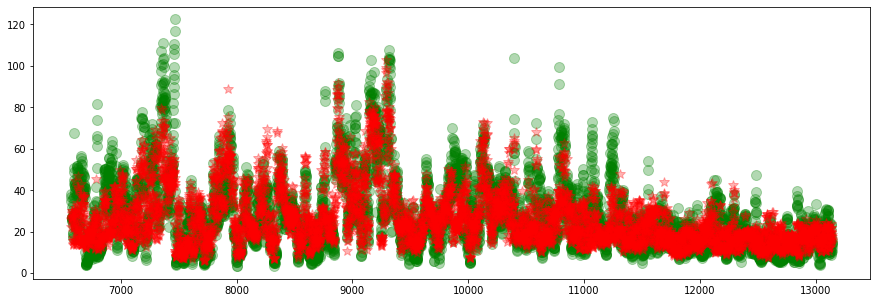

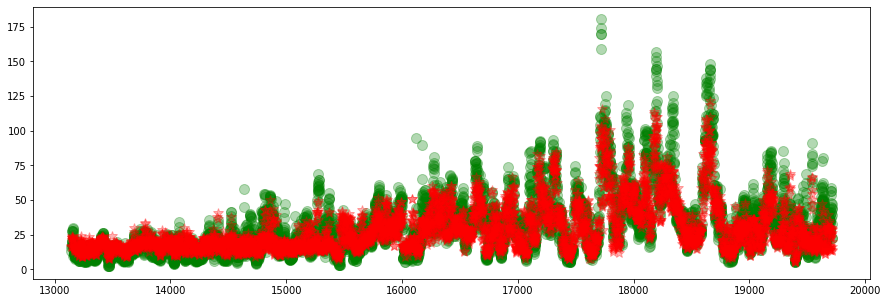

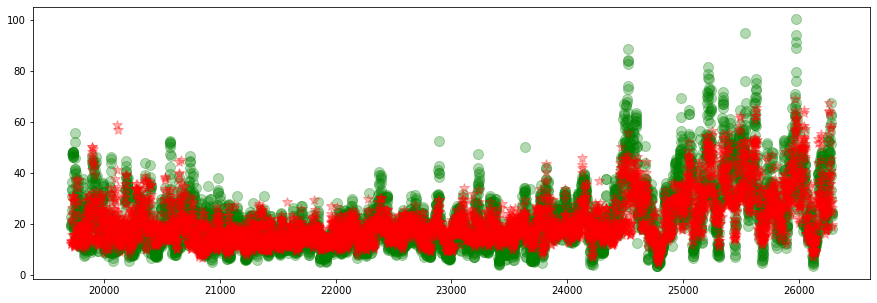

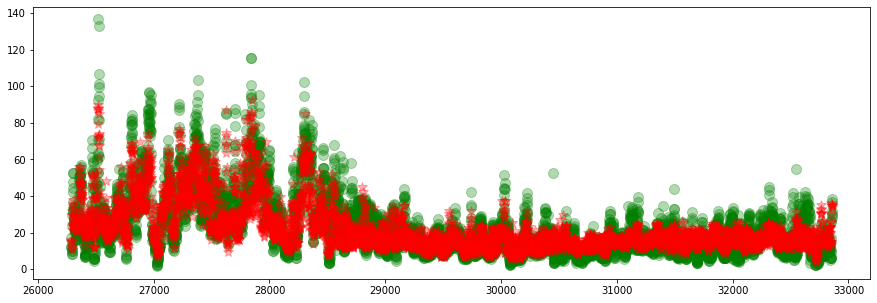

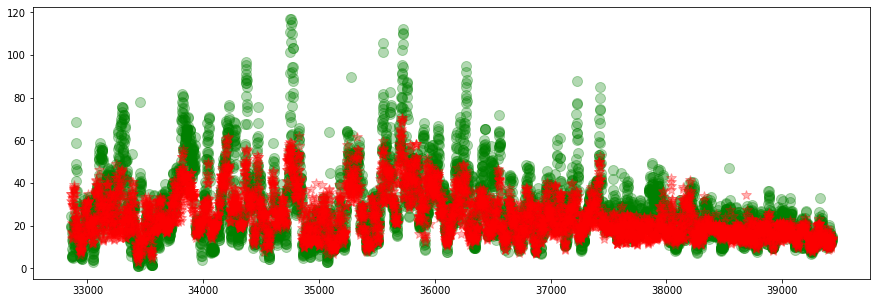

In [12]:
for train_idx, test_idx in tcsv.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    #plt.plot(train_idx, y_true, 'bo', alpha=0.3, ms=10, lw='3', label='train')
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

#### Select new features and run simple models

In [13]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df_train.select_dtypes([np.number, np.bool]).columns
    black_list = ['PM25_nie', 'PM25_wok', 'PM25_nie_log', 'PM25_wok_log', 'PM25_wok_mean']
    return [x for x in feats if x not in black_list]

In [14]:
#get feats
feats = get_feats(train)

In [15]:
for model in models:
    run_model(feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.4135, r2: 47.8%
RandomForestRegressor RMSE: 0.3877, r2: 53.8%
XGBRegressor RMSE: 0.3500, r2: 61.8%
LGBMRegressor RMSE: 0.3487, r2: 62.0%


#### Check feature importance for XGB and LGBM

In [27]:
def feat_importance(model, features):
    skplt.estimators.plot_feature_importances(model, feature_names=df_train[features].columns)
    plt.xticks(rotation=90)
    plt.show();

In [33]:
# fit XGB model

X = df_train[feats].values
y = df_train['PM25_nie_log'].values

XGB_model = xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', random_state=random_state)
XGB_model.fit(X, y)

perm = PermutationImportance(XGB_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=20)

Weight,Feature
0.5426 ± 0.0047,PM25_nie_mean
0.0578 ± 0.0006,dewPoint
0.0574 ± 0.0012,windSpeed_rolling24h
0.0427 ± 0.0006,windSpeed_rolling12h
0.0240 ± 0.0006,windSpeed_lag1h
0.0205 ± 0.0005,year
0.0178 ± 0.0003,visibility
0.0177 ± 0.0009,hour
0.0162 ± 0.0003,dewPoint_rolling168h
0.0154 ± 0.0003,windBearing_lag1h


In [34]:
# fit LGBM model

X = df_train[feats].values
y = df_train['PM25_nie_log'].values

X_test = df_test[feats].values

LGB_model = lgb.LGBMRegressor(max_depth=5, objective='regression', random_state=random_state)
LGB_model.fit(X, y)

perm = PermutationImportance(LGB_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=20)

Weight,Feature
0.5512 ± 0.0115,PM25_nie_mean
0.0680 ± 0.0011,dewPoint
0.0526 ± 0.0013,windSpeed_rolling24h
0.0445 ± 0.0015,windSpeed_rolling12h
0.0243 ± 0.0005,windSpeed_lag1h
0.0239 ± 0.0004,year
0.0195 ± 0.0007,visibility
0.0184 ± 0.0004,hour
0.0171 ± 0.0004,dewPoint_rolling168h
0.0151 ± 0.0007,windBearing_lag1h
